In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Concatenate, BatchNormalization, Bidirectional, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import random
from gensim.models import Word2Vec
from nltk.translate.bleu_score import corpus_bleu
# from PIL import Image




In [ ]:


with open('./flickr8k/captions.txt', 'r') as file:
    lines = file.readlines()

captions_dict = {}
for line in lines:
    image_name, caption = line.strip().split(',', 1)
    if image_name not in captions_dict:
        
        captions_dict[image_name] = []
    captions_dict[image_name].append(caption)

# 5 random images
selected_images = random.sample(list(captions_dict.keys()), 5)

fig, axes = plt.subplots(5, 2, figsize=(15, 25))

for idx, image_name in enumerate(selected_images):
   
    image_path = f'/kaggle/input/flickr8k/Images/{image_name}'
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    
    axes[idx, 0].imshow(image)
    axes[idx, 0].axis('off')
    
    
    
    rect = patches.Rectangle((0, 0), image.shape[1], image.shape[0], linewidth=10, edgecolor='#006600', facecolor='none')
    axes[idx, 0].add_patch(rect)
    
    
    captions = captions_dict[image_name]
    captions_text = "\n".join(captions)
    axes[idx, 1].text(0.5, 0.5, captions_text, ha='center', va='center', wrap=True, fontsize=12)
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
BASE_DIR = './flickr8k'
WORKING_DIR = './'


data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
data.head(10)

In [ ]:
base_model = Xception(weights='imagenet', include_top=False) #with imagenet weights

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
x = base_model.output # since xception does not have any fully connected layers 
x = GlobalAveragePooling2D()(x) # added a avg pooling layer
model = Model(inputs=base_model.input, outputs=x)

In [6]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │        864 │ input_layer[0][0] │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, None,      │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, None,      │          0 │ block1_conv1_bn[… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, None,      │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, None,      │          0 │ block1_conv2_bn[… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, None,      │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, None,      │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, None,      │          0 │ block2_sepconv1_… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, None,      │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, None,      │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │      8,192 │ block1_conv2_act… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None,      │          0 │ block2_pool[0][0… │
│                     │ None, 128)        │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, None,      │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(299, 299))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [8]:
#Load features
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [9]:
#Load Captions
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [10]:
# Create mapping of image to captions
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [11]:
#function to clean the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption
clean(mapping)

In [12]:
# Word2vector for vector embeddings of the text
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption.split())
word2vec_model = Word2Vec(all_captions, vector_size=512, window=5, min_count=1, workers=4)
vocab_size = len(word2vec_model.wv.index_to_key) + 1

In [13]:
# Create embedding matrix
embedding_dim = 512
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = {word: idx for idx, word in enumerate(word2vec_model.wv.index_to_key, 1)}
for word, idx in word_index.items():
    embedding_matrix[idx] = word2vec_model.wv[word]

In [14]:
max_length = max(len(caption) for caption in all_captions)
max_length

35

In [15]:
# Train-test split
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [16]:
# Data generator function
def data_generator(data_keys, mapping, features, word_index, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = [word_index[word] for word in caption.split() if word in word_index]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield (np.array(X1), np.array(X2)), np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0

In [17]:
# Model architecture
inputs1 = Input(shape=(2048,))
fe1 = BatchNormalization()(inputs1)
fe2 = Dense(512, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True, weights=[embedding_matrix], trainable=False)(inputs2)
se2 = BatchNormalization()(se1)
se3 = Bidirectional(LSTM(256))(se2)

decoder = Concatenate()([fe2, se3])
decoder2 = Dense(512, activation='relu')(decoder)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
optimizer = Adam(learning_rate=1e-4, clipvalue=5.0)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
# model.summary()

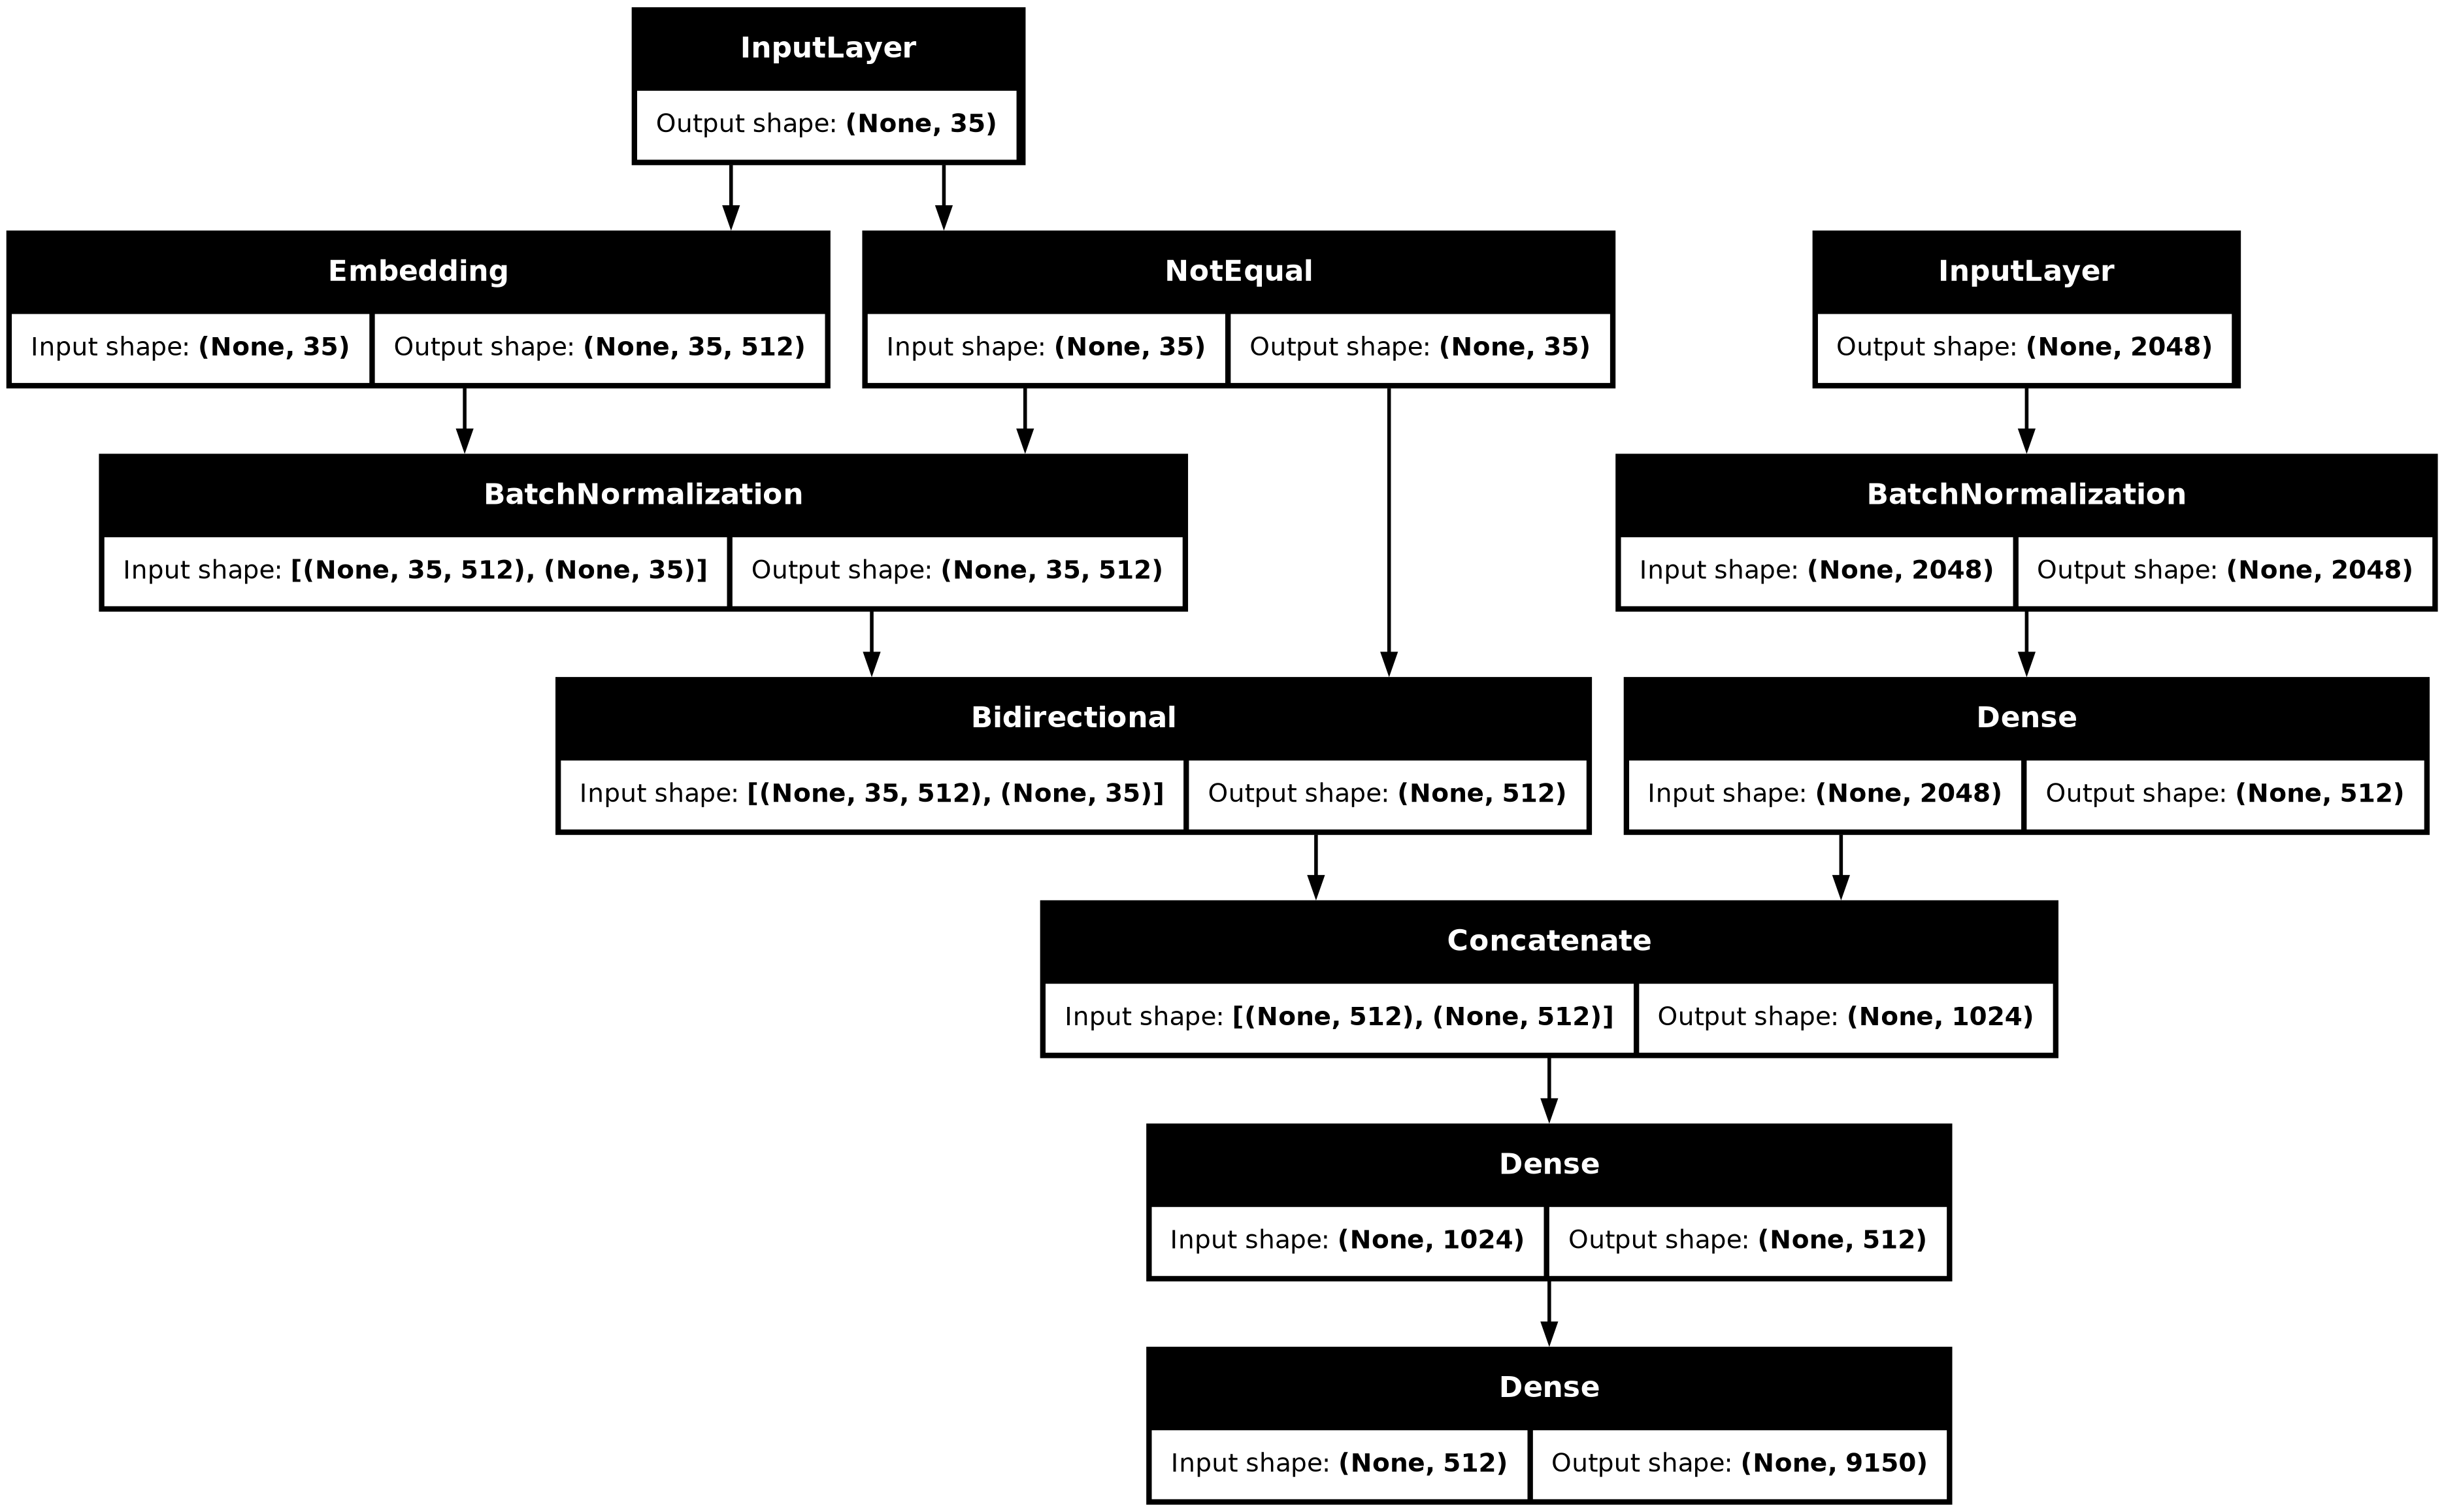

In [18]:
plot_model(model, show_shapes=True)

In [19]:
# Train the model
epochs = 64  #epochs > 64 causing memory error
batch_size = 32
steps = len(train) // batch_size
checkpoint_filepath = 'model_checkpoint.keras'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)

In [20]:
for i in range(epochs):
    generator = data_generator(train, mapping, features, word_index, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[model_checkpoint_callback])


227/227 ━━━━━━━━━━━━━━━━━━━━ 65s 256ms/step - accuracy: 0.1123 - loss: 6.7998


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 257ms/step - accuracy: 0.2374 - loss: 4.5008
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 255ms/step - accuracy: 0.2783 - loss: 3.9691
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 256ms/step - accuracy: 0.3008 - loss: 3.6774
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 255ms/step - accuracy: 0.3165 - loss: 3.4691
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 256ms/step - accuracy: 0.3294 - loss: 3.3021
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 254ms/step - accuracy: 0.3409 - loss: 3.1588
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 255ms/step - accuracy: 0.3520 - loss: 3.0313
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 255ms/step - accuracy: 0.3630 - loss: 2.9163
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 256ms/step - accuracy: 0.3756 - loss: 2.8131
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 254ms/step - accuracy: 0.3885 - loss: 2.7225
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 255ms/step - accuracy: 0.4006 - loss: 2.6431
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 257ms/step - accuracy: 0.4118 - loss: 2.5724
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 255ms/step - accuracy: 0.4209 -

In [21]:
# Prediction functions
def idx_to_word(integer, word_index):
    for word, index in word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, word_index, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word_index[word] for word in in_text.split() if word in word_index]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, word_index)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [22]:
actual, predicted = list(), list()
for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], word_index, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.509804
BLEU-2: 0.280912


In [23]:
model.save(WORKING_DIR + '/model.keras')

In [24]:
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    y_pred = predict_caption(model, features[image_id], word_index, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [8]:
# generate_caption('1012212859_01547e3f17.jpg')

In [9]:
# generate_caption('116409198_0fe0c94f3b.jpg')

In [ ]:
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    y_pred = predict_caption(model, features[image_id], word_index, max_length)
    return y_pred.replace("startseq ", "").replace(" endseq", "")